# Makine Öğrenmesi İle Sahte Haber Tespiti


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Verisetini Okuma

In [2]:
fake = pd.read_csv("data/Fake.csv")
true = pd.read_csv("data/True.csv")

In [3]:
fake.shape

(23481, 4)

In [4]:
true.shape

(21417, 4)

## Veri Temizleme ve Hazırlama

In [5]:
# Sahte ve gerçek haberleri takip edebilmek için flag koyuyoruz.
fake['targets'] = 'fake'
true['targets'] = 'true'

In [6]:
# verileri birleştirelim
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [7]:
# verileri random karıştıralım
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [8]:
data.head()

,title,text,subject,date,targets
0,Xi urges BRICS grouping to push for more 'just...,"XIAMEN, China (Reuters) - Chinese President Xi...",worldnews,"September 5, 2017",true
1,UPDATED VIDEO: IS THIS AMERICA? CONSERVATIVES ...,This story should send chills down the spine o...,politics,"Apr 21, 2015",fake
2,Former Trump adviser Papadopoulos pleads guilt...,WASHINGTON (Reuters) - An obscure Trump campai...,politicsNews,"October 30, 2017",true
3,[VIDEO] HUNDREDS OF MORMON FUNDAMENTALISTS SUR...,Evil hiding under the banner of religion in ...,politics,"Apr 7, 2015",fake
4,U.S. House Speaker backs intelligence panel ch...,WASHINGTON (Reuters) - The top Republican in C...,politicsNews,"March 28, 2017",true


In [9]:
# date sütununa ihtiyacımız olmadığı için silelim
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,targets
0,Xi urges BRICS grouping to push for more 'just...,"XIAMEN, China (Reuters) - Chinese President Xi...",worldnews,true
1,UPDATED VIDEO: IS THIS AMERICA? CONSERVATIVES ...,This story should send chills down the spine o...,politics,fake
2,Former Trump adviser Papadopoulos pleads guilt...,WASHINGTON (Reuters) - An obscure Trump campai...,politicsNews,true
3,[VIDEO] HUNDREDS OF MORMON FUNDAMENTALISTS SUR...,Evil hiding under the banner of religion in ...,politics,fake
4,U.S. House Speaker backs intelligence panel ch...,WASHINGTON (Reuters) - The top Republican in C...,politicsNews,true


In [10]:
# sadece haber içeriğini kullanacağımız için başlığı da silebiliriz.
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,targets
0,"XIAMEN, China (Reuters) - Chinese President Xi...",worldnews,true
1,This story should send chills down the spine o...,politics,fake
2,WASHINGTON (Reuters) - An obscure Trump campai...,politicsNews,true
3,Evil hiding under the banner of religion in ...,politics,fake
4,WASHINGTON (Reuters) - The top Republican in C...,politicsNews,true


In [11]:
# cümleleri küçük harflerle yazalım

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,targets
0,"xiamen, china (reuters) - chinese president xi...",worldnews,true
1,this story should send chills down the spine o...,politics,fake
2,washington (reuters) - an obscure trump campai...,politicsNews,true
3,evil hiding under the banner of religion in ...,politics,fake
4,washington (reuters) - the top republican in c...,politicsNews,true


In [12]:
# noktalama işaretlerini de kaldıralım.

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [13]:
# kontrol edelim
data.head()

,text,subject,targets
0,xiamen china reuters chinese president xi jin...,worldnews,true
1,this story should send chills down the spine o...,politics,fake
2,washington reuters an obscure trump campaign ...,politicsNews,true
3,evil hiding under the banner of religion in ...,politics,fake
4,washington reuters the top republican in cong...,politicsNews,true


In [14]:
# etkisiz kelimeleri (stopwords) kaldıralım.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

data['text'] = data['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mehme\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
data.head()

,text,subject,targets
0,xiamen china reuters chinese president xi jinp...,worldnews,true
1,story send chills spine every american communi...,politics,fake
2,washington reuters obscure trump campaign advi...,politicsNews,true
3,evil hiding banner religion backyard 32yearold...,politics,fake
4,washington reuters top republican congress tue...,politicsNews,true


## Temel Verileri Bulma

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


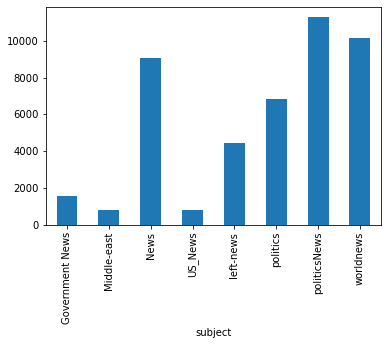

In [16]:
# hangi konudan kaç makale var bulalım. 
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

targets
fake    23481
true    21417
Name: text, dtype: int64


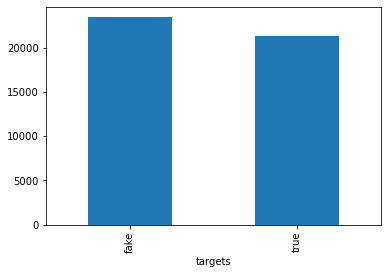

In [17]:
# Makalelerin ne kadarı gerçek/sahte bakalım
print(data.groupby(['targets'])['text'].count())
data.groupby(['targets'])['text'].count().plot(kind="bar")
plt.show()

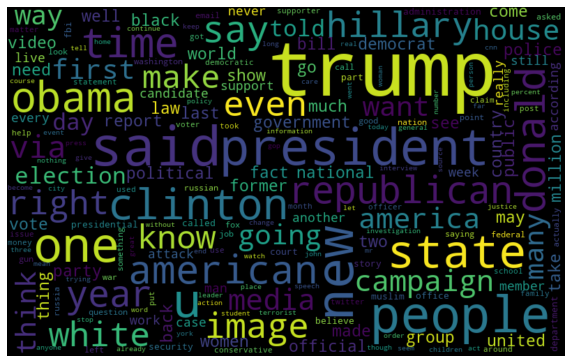

In [18]:
# Sahte haberler için WordCloud (kelime bulutu)
from wordcloud import WordCloud

fake_data = data[data["targets"] == "fake"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

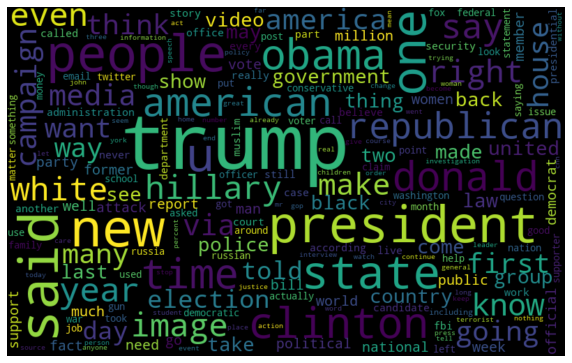

In [19]:
# Gerçek haberler için WorldCloud
from wordcloud import WordCloud

real_data = data[data["targets"] == "true"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [20]:
# En sık kullanılan kelimelere bakalım 
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

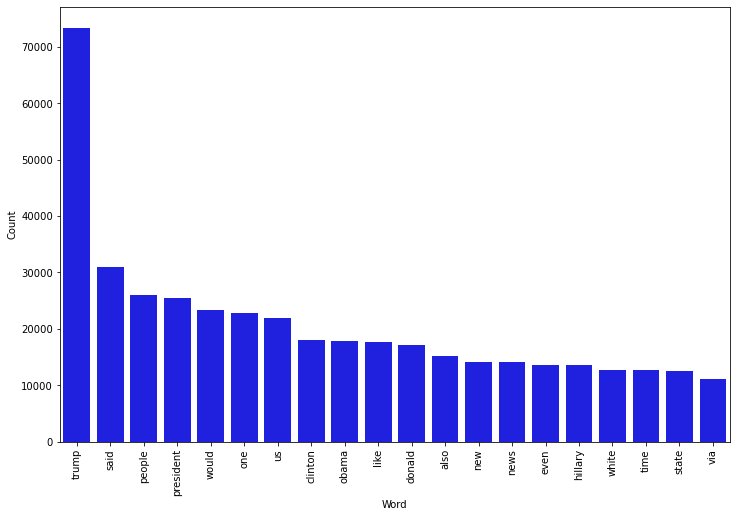

In [21]:
# Sahte haberlerde en sık kullanılan kelimeler
counter(data[data["targets"] == "fake"], "text", 20)

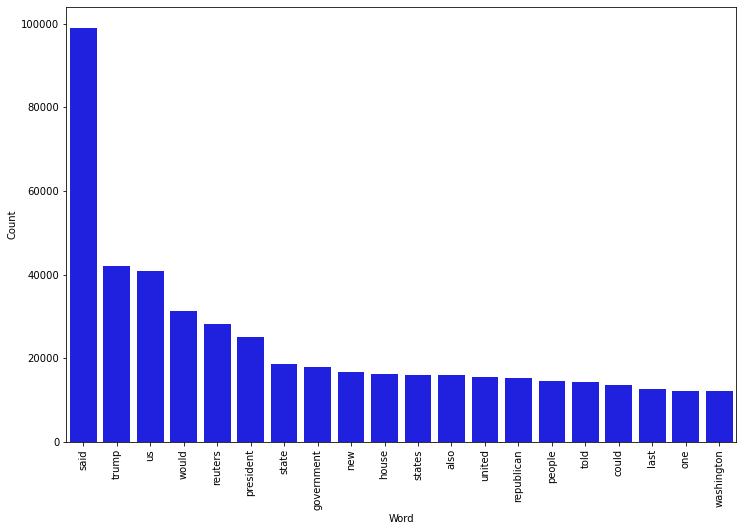

In [22]:
# Gerçek haberlerde en sık kullanılan kelimeler
counter(data[data["targets"] == "true"], "text", 20)

## Verinin Modellenmesi

In [23]:
# Karşılık matrisini çizdirelim (confusion matrix) 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Veriyi Hazırlama

In [24]:
# Veriyi eğitim ve test olarak ayıralım
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.targets, test_size=0.2, random_state=42)

# **Naive Bayes Algoritması**




In [25]:
#Bayes kullanarak veriyi sınıflandıralım
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.29%


Confusion matrix, without normalization


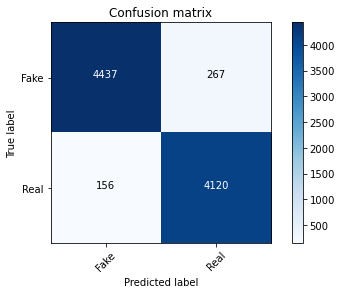

In [26]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Lojistik regression kullanarak veri kümesini analiz etme**

In [27]:
# TF-IDF yi vektörleştirme
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# modeli eğitelim
model = pipe.fit(X_train, y_train)

# Doğruluk
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 98.9%


Confusion matrix, without normalization


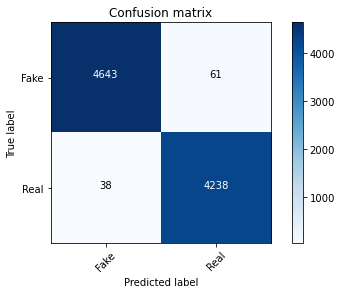

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Karar Ağacı Algoritması (Decision Tree)**

In [29]:
from sklearn.tree import DecisionTreeClassifier

# TF-IDF yi vektörleştirme
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Modeli eğitelim
model = pipe.fit(X_train, y_train)

# doğruluk oranı
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.55%


Confusion matrix, without normalization


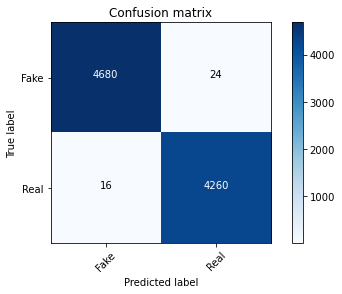

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Random Forest Algoritması**

In [31]:
from sklearn.ensemble import RandomForestClassifier
#TF-IDF yi vektörleştirme
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])
#Modeli Eğitme
model = pipe.fit(X_train, y_train)
#Doğruluğu
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.38%


Confusion matrix, without normalization


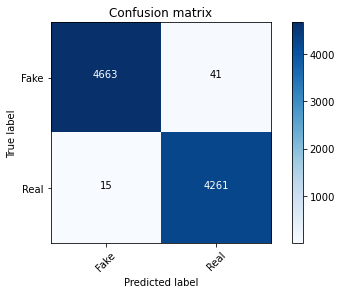

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

## **SVM Algoritması**

In [33]:
from sklearn import svm

#SVM sınıflandırıcısı oluşturma
clf = svm.SVC(kernel='linear') # Linear Kernel

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', clf)])
#Modeli Eğitme
model = pipe.fit(X_train, y_train)
#Doğruluk oranı
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['SVM'] = round(accuracy_score(y_test, prediction)*100,2)



accuracy: 99.64%


Confusion matrix, without normalization


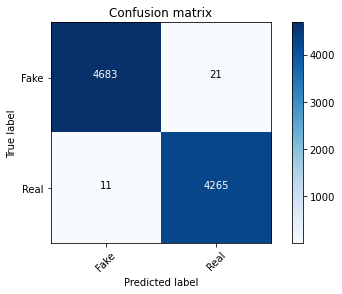

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Fake', 'Real'])

# **Farklı Modellerin Karşılaştırılması**

([<matplotlib.axis.YTick at 0x12704544310>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

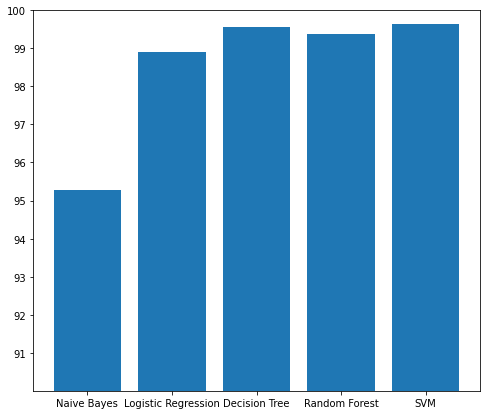

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()))
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100))